
# RNN Dead Layer Fit Project
## MC2 Fixed DLF=1, Quantile Regression Loss on DLF Label


## Import general packages

In [1]:
#check env
import os
print (os.environ['CONDA_DEFAULT_ENV'])

/unix/legend/abi/ML_DL/MLenv


In [2]:
#General
import sys
import json
import yaml
import pandas as pd

#RNN imports
import numpy as np
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper #problem installing: !pip install torchsnooper --user #this worked for installing torchsnooper
import h5py
import re
from tqdm import tqdm
from torch.cuda.amp import autocast

torch.cuda.empty_cache()


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cuda:0")
print(DEVICE)
torch.cuda.is_available()

/unix/legend/abi/ML_DL/MLenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


True

## Import dataset and RNN functions

In [3]:
from src.data import *
from src.RNN import *
from src.training import *

## Get relevant paths

In [4]:
# Data paths:
CodePath = os.path.dirname(os.path.abspath("__file__"))
DATA_PATH = CodePath+"/data/V05268A_data/data_hist_Ba_V05268A.h5"

# MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A/"
# MC_PATH_FCCDonly = CodePath+"/data/V05268A_data/training_data_V05268A_FCCDonly/"

MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_randomDLFs/"
MC_PATH_FCCDonly = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_DLF1/"

## Plot Training Data

no files:  4908


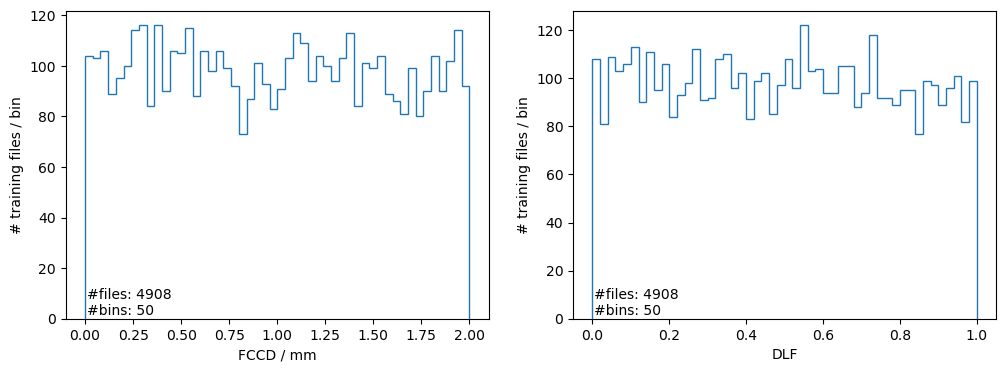

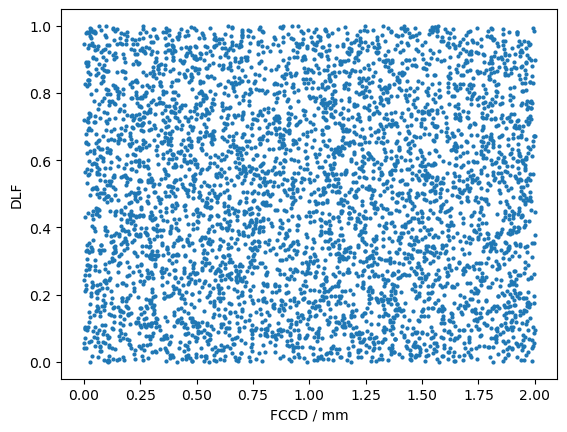

In [5]:
#Plot Training Data
plotTrainingData(MC_PATH)

no files:  4991


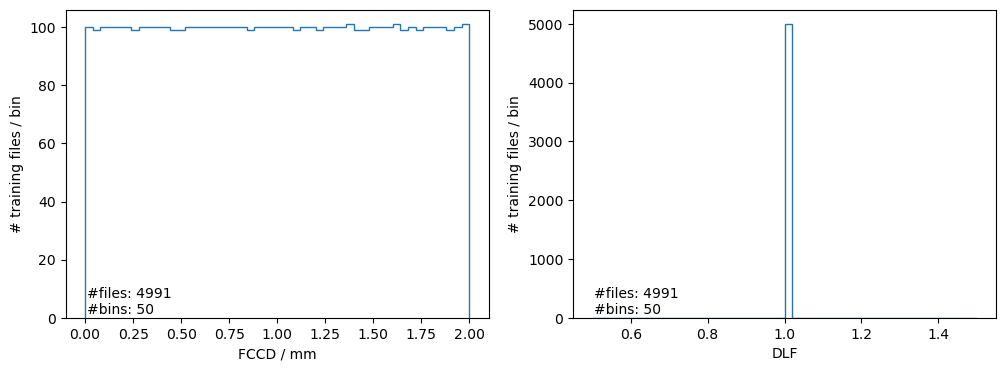

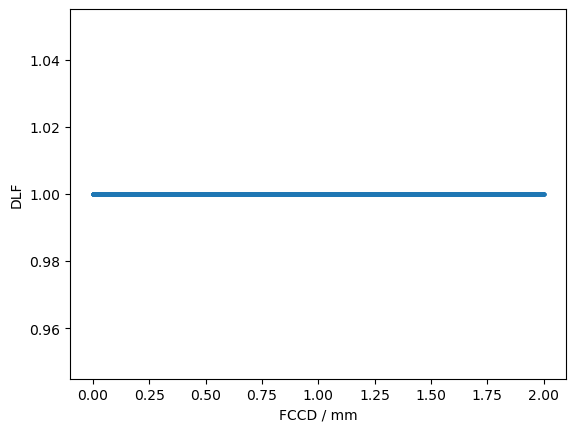

In [6]:
#Plot Training Data
plotTrainingData(MC_PATH_FCCDonly)

# -------------------------------------------------------
# WORKFLOW
# -------------------------------------------------------

# TRAINING 1: full dataset

In [7]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
RNN_ID = "RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_fulldataset_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Training  (DO NOT RERUN UNLESS NECESSARY)

In [8]:
#load dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)


100%|██████████████████████████████████████████████████████████████| 4908/4908 [00:42<00:00, 115.31it/s]


(4908, 900)


100%|██████████████████████████████████████████████████████████████| 4991/4991 [00:36<00:00, 134.96it/s]


(4991, 900)


RNN_MC2DLF1_20epochs_LR0.005_fulldataset_10000trials
#params 2106628
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 20
Training network...
Epoch [1/20], Iter [1750/1750] Loss: 0.1756
Testing/Validating...


100%|█████████████████████████████████████████████████████████████████| 750/750 [01:15<00:00,  9.99it/s]


accuracy_FCCD:  0.899
accuracy_DLF:  0.9133333333333333

EPOCH:  2 / 20
Training network...
Epoch [2/20], Iter [1088/1750] Loss: 0.1524

KeyboardInterrupt: 

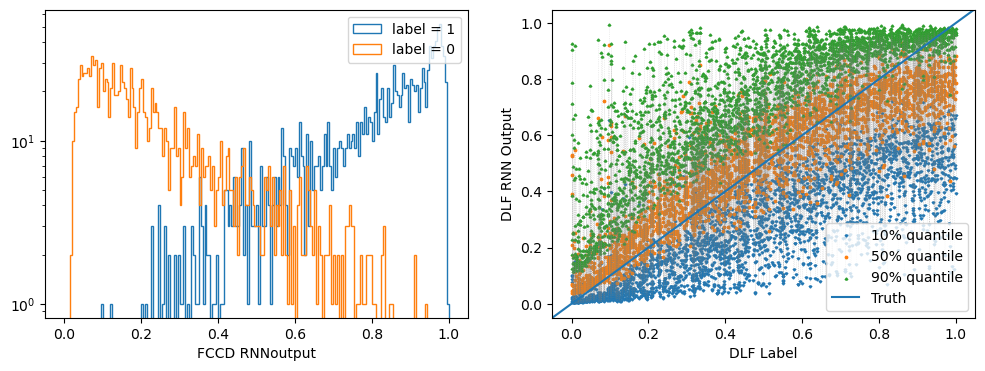

In [9]:
#run training
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(dataset, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, 
                                                                   plot_training_results = True, RNN_ID = RNN_ID, quantileRegressionDLF=True)


In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [ ]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)


In [ ]:
# Load saved model
RNNclassifier_fulldataset = RNN(dataset.get_histlen(),4)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_fulldataset.load_state_dict(torch.load(model_path))
RNNclassifier_fulldataset.eval()

In [ ]:
#testing
accuracies_fulldataset = test_RNN(RNNclassifier_fulldataset, test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True)
    

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, RNN_ID=RNN_ID, save_plots = True,
                                          quantileRegressionDLF=True)


# TRAINING 2: restircted dataset - Max FCCD diff = 0.5 mm
Only train on FCCDs with a max diff of 0.5 mm

In [ ]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
maxFCCDdiff = 0.5
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Testing - on maxFCCDdiff=0.5mm

In [ ]:
#Load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, 
                                               size=dataset_size, path_MC2 = MC_PATH_FCCDonly)


In [ ]:
# Load saved model
RNNclassifier_maxFCCDdiff0_5mm = RNN(dataset.get_histlen(),4)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_5mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_5mm.eval()

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_5mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True)
    

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True)


## Testing - on full dataset

In [ ]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_5mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True, train_restricted_test_fulldataset = True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True, train_restricted_test_fulldataset = True)
    

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True,
                                          train_restricted_test_fulldataset = True)


# TRAINING 3: restircted dataset - Max FCCD diff = 0.25 mm

In [ ]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
maxFCCDdiff = 0.25
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Testing - on maxFCCDdiff=0.25mm

In [ ]:
#Load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, 
                                               size=dataset_size, path_MC2 = MC_PATH_FCCDonly)


In [ ]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm = RNN(dataset.get_histlen(),4)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm.eval()

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_25mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True)

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True)

## Testing - on full dataset

In [ ]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_25mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True, train_restricted_test_fulldataset = True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True, train_restricted_test_fulldataset = True)
    

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True,
                                          train_restricted_test_fulldataset = True)

# TRAINING 3: restircted dataset - Max FCCD diff = 0.1 mm

In [ ]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
maxFCCDdiff = 0.1
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Testing - on maxfccddiff = 0.1 mm

In [ ]:
#Load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, 
                                               size=dataset_size, path_MC2 = MC_PATH_FCCDonly)


In [ ]:
# Load saved model
RNNclassifier_maxFCCDdiff0_1mm = RNN(dataset.get_histlen(),4)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_1mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_1mm.eval()

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_1mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True)

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True)

## Testing on full dataset

In [ ]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_1mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True, train_restricted_test_fulldataset = True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True, train_restricted_test_fulldataset = True)
    

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True,
                                          train_restricted_test_fulldataset = True)

# TRAINING 4: restircted dataset - Max FCCD diff = 0.05 mm

In [ ]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
maxFCCDdiff = 0.05
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Testing - on maxfccddiff =0.05 mm

In [ ]:
#Load restricted dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, 
                                               size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

In [ ]:
# Load saved model
RNNclassifier_maxFCCDdiff0_05mm = RNN(dataset.get_histlen(),4)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_05mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_05mm.eval()

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_05mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True)

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True)

## Testing - on full dataset

In [ ]:
#load full dataset
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

In [ ]:
test_RNN(RNNclassifier_maxFCCDdiff0_05mm , test_loader, RNN_ID=RNN_ID, 
                                      misclassified_trials_plots = True, save_results = True, roc_curve=True,
                                     quantileRegressionDLF=True, train_restricted_test_fulldataset = True)

In [ ]:
#Plot multple attention scores
plot_multiple_attention(dataset, test_loader, model_path, attention_mechanism="normal", RNN_ID=RNN_ID, 
                        save_plots = True, quantileRegressionDLF=True, train_restricted_test_fulldataset = True)
    

In [ ]:
#Plot average attention score
average_attention = plot_average_attention(dataset, test_loader, model_path, attention_mechanism="normal", 
                                           RNN_ID=RNN_ID, save_plots = True, quantileRegressionDLF=True,
                                          train_restricted_test_fulldataset = True)